In [1]:
%matplotlib inline
import numpy
import pandas
import theano
import theano.tensor as T
import matplotlib.pyplot as plt

import os, sys
sys.path.append('../code')

from retina_best import *

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
data = pd.read_csv('../data/hits.csv', index_col=0)

# Reconstruction

In [4]:
from combination import Combinator
from metrics import TracksReconstractionMetrics, CombinatorQuality

In [12]:
%%time
event_ids = numpy.unique(data.EventID.values)

tracks12 = {}
tracks34 = {}
tracks_comb = {}

tracks_metrics_before_all = pandas.DataFrame(columns=['EventID', 'AvgEff', 'RecoEff', 'GhostRate', 'CloneRate'])

tracks_metrics_after_all = pandas.DataFrame(columns=['EventID', 'AvgEff', 'RecoEff', 'GhostRate', 'CloneRate'])

combinations = pandas.DataFrame(columns=['EventID', 'TrackIDBefore', 'TrackIDAfter', 'Charge', 'PInv'])
combinations_true = pandas.DataFrame(columns=['EventID', 'IsTrueCombination', 'PdgCode', 'Charge', 
                                                 'IsTrueCharge', 'TruePInv', 'PErr', 'Label'])

combinations_quality = pandas.DataFrame(columns=['EventID', 'RecoEff', 'GhostRate', 'CloneRate', 'NCombined'])

pass_stages = pandas.DataFrame(columns=['RecoEvents', 'Y12', 'Y34', 'Combination', 'Matching'])

for event_id in event_ids:
    try:
        # Get an event
        event = data[data.EventID == event_id]
        event12 = event[(event.StatNb == 1) + (event.StatNb == 2)]
        event34 = event[(event.StatNb == 3) + (event.StatNb == 4)]

        # Tracks reconstruction before the magnet
        tr2d = RetinaTrackReconstruction(pre_sigma=0.8, inlier_treshold=0.7, x_resolution=1, y_resolution=1,\
                                         de_popsize=20, adjusting=True, de_seed=42)
        tr2d.fit(event)

        labels12 = tr2d.labels_[0]
        tracks_params12 = tr2d.tracks_params_[0]

        # Quality metrics of the reconstruction
        trm12 = TracksReconstractionMetrics(0.2)
        trm12.fit(labels12, event12)

        tracks_metrics_before_all.loc[len(tracks_metrics_before_all)] = [event_id, 
                                                                     trm12.avg_efficiency_, 
                                                                     trm12.recognition_efficiency_, 
                                                                     trm12.ghost_rate_, 
                                                                     trm12.clone_rate_]

        labels34 = tr2d.labels_[1]
        tracks_params34 = tr2d.tracks_params_[1]

        # Quality metrics of the reconstruction
        trm34 = TracksReconstractionMetrics(0.2)
        trm34.fit(labels34, event34)

        tracks_metrics_after_all.loc[len(tracks_metrics_after_all)] = [event_id, 
                                                                     trm34.avg_efficiency_, 
                                                                     trm34.recognition_efficiency_, 
                                                                     trm34.ghost_rate_, 
                                                                     trm34.clone_rate_]


        # Save the reconstructed tracks
        tracks12[event_id] = {'labels':labels12, 'params':tracks_params12}
        tracks34[event_id] = {'labels':labels34, 'params':tracks_params34}


        # Combination of the tracks before and after the magnet
        comb = Combinator()
        comb.combine(tracks_params12, tracks_params34)

        for num in range(len(comb.tracks_combinations_)):

            combinations.loc[len(combinations)] = [event_id, 
                                                   comb.tracks_combinations_[num][0], 
                                                   comb.tracks_combinations_[num][1], 
                                                   comb.charges_[num], 
                                                   comb.inv_momentums_[num]]

        # Quality of the combination

        cq = CombinatorQuality()
        cq.fit(labels12, labels34, comb.tracks_combinations_, comb.charges_, comb.inv_momentums_, event12, event34)

        combinations_quality.loc[len(combinations_quality)] = [event_id, 
                                                               cq.reco_eff_, 
                                                               cq.ghost_rate_, 
                                                               cq.clone_rate_, 
                                                               cq.n_combined_]

        for num in range(len(cq.check_tracks_combinations_)):

            combinations_true.loc[len(combinations_true)] = [event_id, 
                                                                   cq.check_tracks_combinations_[num], 
                                                                   cq.true_pdg_codes_[num], 
                                                                   cq.true_charges_[num],
                                                                   cq.check_charges_[num], 
                                                                   cq.true_inv_momentums_[num], 
                                                                   cq.momentums_err_[num],
                                                                   cq.labels_[num]]



        # Overall quality
        pass_stages.loc[len(pass_stages)] = numpy.array([1, 
                                                         (trm12.recognition_efficiency_ == 1)*1,
                                                         (trm34.recognition_efficiency_ == 1)*1, 
                                                         (cq.n_combined_ >= 2)*1,
                                                         (cq.reco_eff_ == 1)*1]).cumprod()

        if not (trm12.recognition_efficiency_ == 1):
            print 1, event_id
        elif not (trm34.recognition_efficiency_ == 1):
            print 2, event_id
        elif not (cq.n_combined_ >= 2):
            print 3, event_id



        # Save the tracks combination
        tracks_comb[event_id] = {'tracks_combinations':comb.tracks_combinations_,
                                 'charges':comb.charges_,
                                 'inv_momentums':comb.inv_momentums_}
    except:
        print 'crashed at' + str(event_id)

crashed at1528
crashed at2040
1 3165
2 3670
CPU times: user 1h 5min 5s, sys: 2.21 s, total: 1h 5min 7s
Wall time: 1h 5min 4s


# Quality

# Stations 1&2

## track efficiency

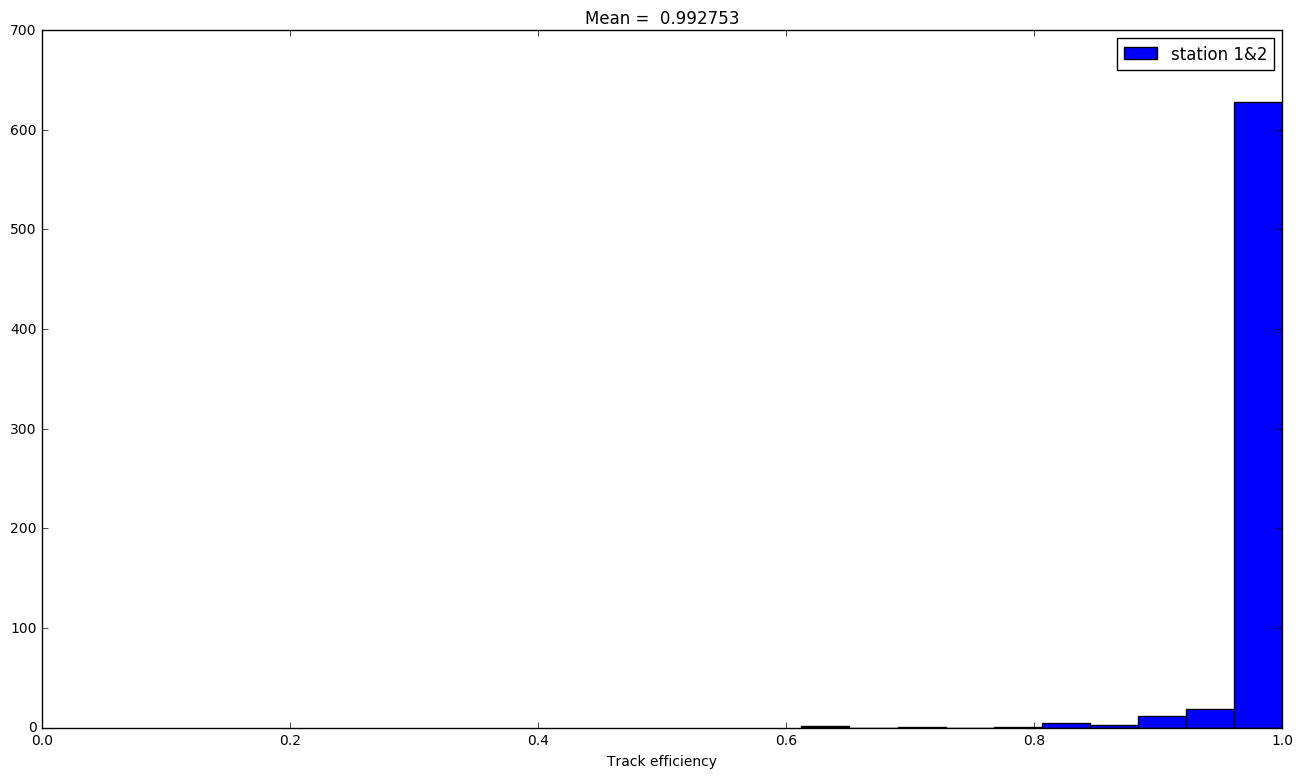

In [13]:
plt.figure(figsize=(16, 9))

eff_station = tracks_metrics_before_all.AvgEff.values
plt.title('Mean = % f' % numpy.array(eff_station).mean())
plt.hist(eff_station, label='station 1&2')
plt.xlabel('Track efficiency')
plt.xlim(0, 1)
plt.legend(loc='best')

plt.show()

## reconstruction_efficiency

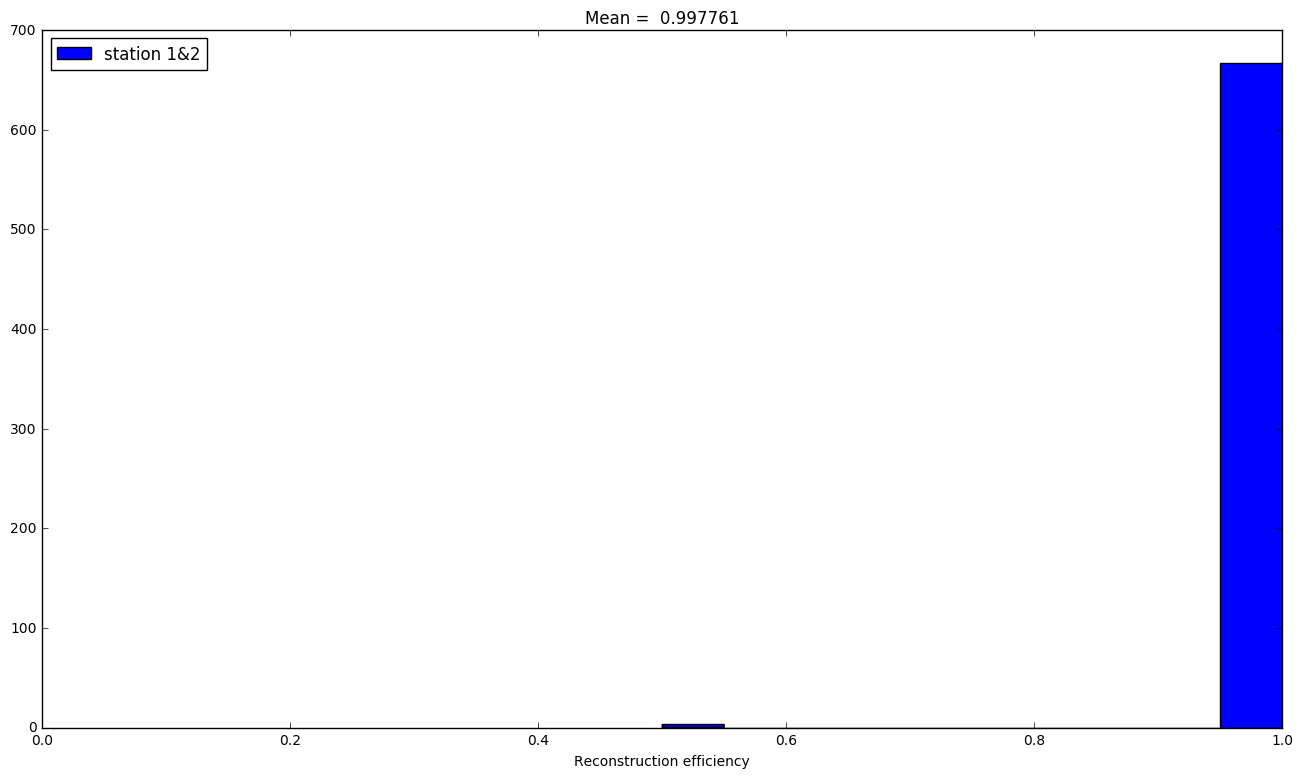

In [14]:
plt.figure(figsize=(16, 9))

eff_station = tracks_metrics_before_all.RecoEff.values
plt.title('Mean = % f' % numpy.array(eff_station).mean())
plt.hist(eff_station, label='station 1&2')
plt.xlabel('Reconstruction efficiency')
plt.xlim(0, 1)
plt.legend(loc='best')

plt.show()

# Stations 3&4

## track efficiency

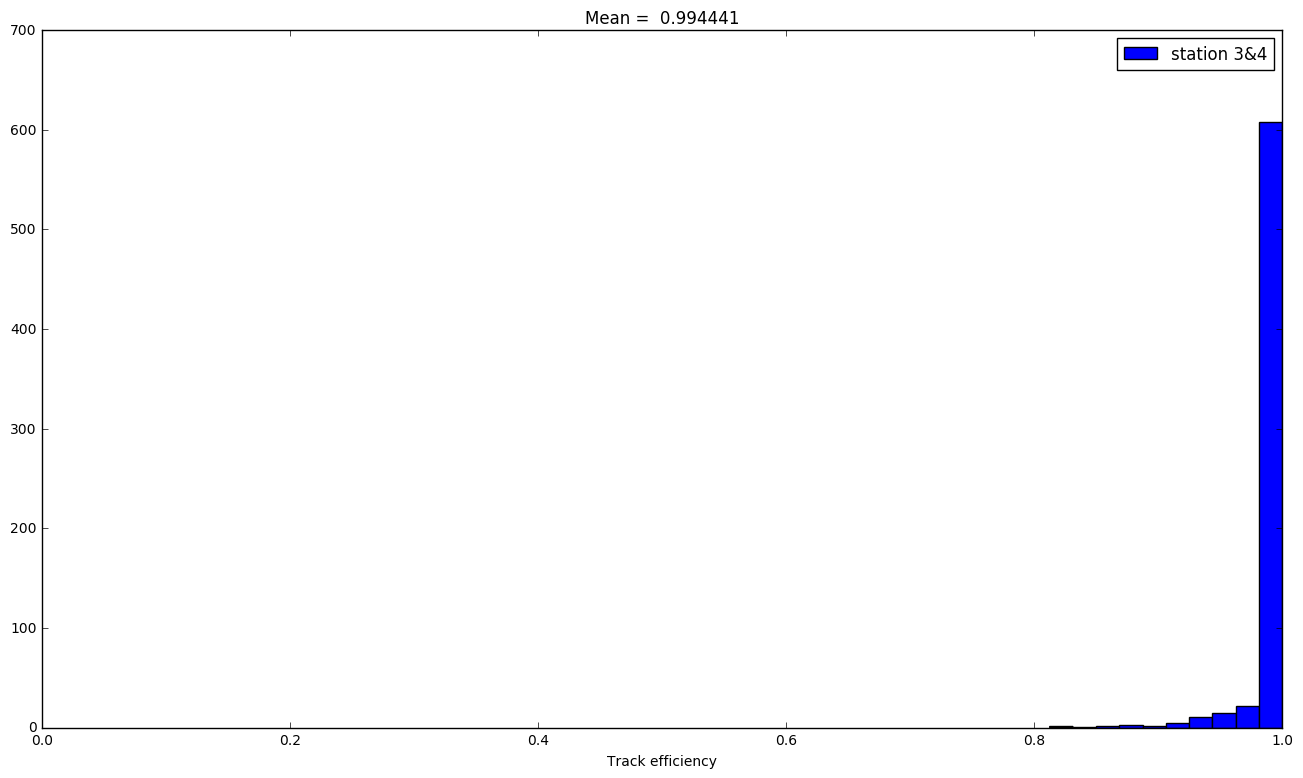

In [15]:
plt.figure(figsize=(16, 9))

eff_station = tracks_metrics_after_all.AvgEff.values
plt.title('Mean = % f' % numpy.array(eff_station).mean())
plt.hist(eff_station, label='station 3&4')
plt.xlabel('Track efficiency')
plt.xlim(0, 1)
plt.legend(loc='best')

plt.show()

## reconstruction efficiency

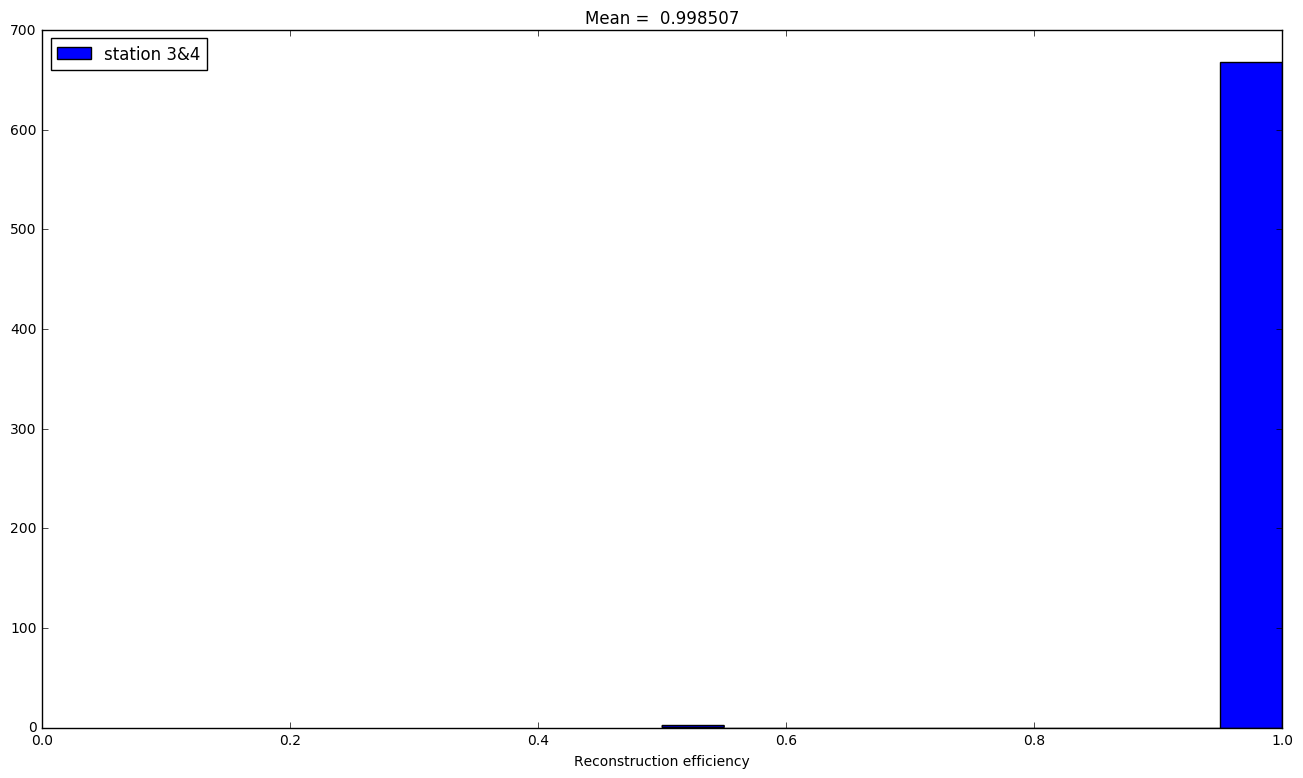

In [16]:
plt.figure(figsize=(16, 9))

eff_station = tracks_metrics_after_all.RecoEff.values
plt.title('Mean = % f' % numpy.array(eff_station).mean())
plt.hist(eff_station, label='station 3&4')
plt.xlabel('Reconstruction efficiency')
plt.xlim(0, 1)
plt.legend(loc='best')

plt.show()

# Combination

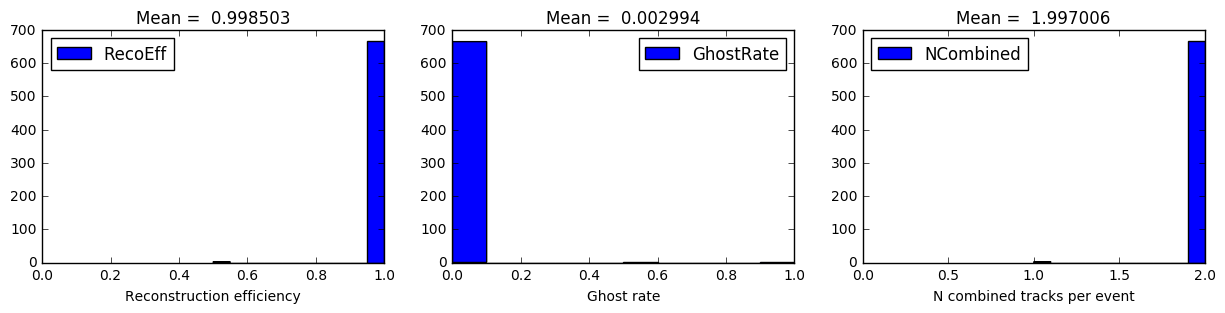

In [17]:
plt.figure(figsize=(15, 3))

plt.subplot(1,3,1)
eff = combinations_quality.RecoEff.values
plt.title('Mean = % f' % numpy.array(eff).mean())
plt.hist(eff, label='RecoEff')
plt.xlabel('Reconstruction efficiency')
plt.xlim(0, 1)
plt.legend(loc='best')

plt.subplot(1,3,2)
ghost = combinations_quality.GhostRate.values
plt.title('Mean = % f' % numpy.array(ghost).mean())
plt.hist(ghost, label='GhostRate')
plt.xlabel('Ghost rate')
plt.xlim(0, 1)
plt.legend(loc='best')

plt.subplot(1,3,3)
n_combined = combinations_quality.NCombined.values
plt.title('Mean = % f' % numpy.array(n_combined).mean())
plt.hist(n_combined, label='NCombined')
plt.xlabel('N combined tracks per event')
plt.xlim(0, 2)
plt.legend(loc='best')

plt.show()

# Ratio of the events passes through the stages

99.7005988024


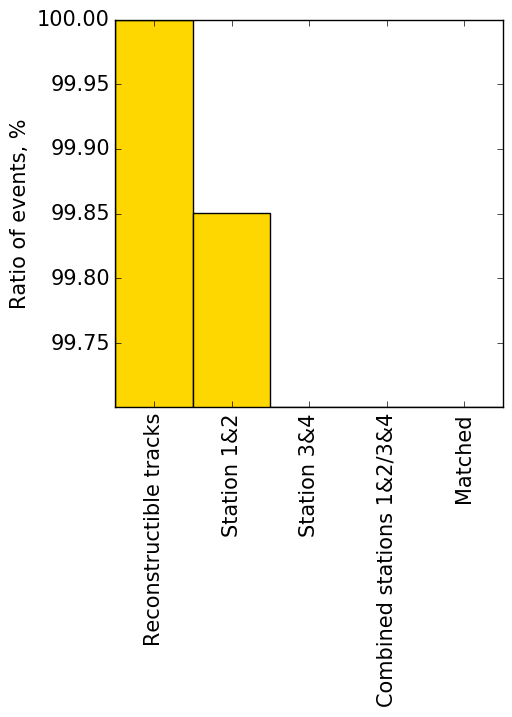

In [18]:
bar_labels = ['Reconstructible tracks', 
              'Station 1&2',
              'Station 3&4',
              'Combined stations 1&2/3&4',
              'Matched']

bar_values = pass_stages.sum(axis=0).values
bar_values = bar_values / bar_values[0] * 100


print bar_values[-1]

x = range(len(bar_labels))
plt.figure(figsize=(5,5))
plt.bar(x, bar_values, width=1., color='gold', align='center')
plt.xticks(x, bar_labels, rotation=90, size=15)
plt.yticks(size=15)
plt.xlim(-0.5, 4.5)
plt.ylim(bar_values[-1], bar_values[0])
plt.ylabel('Ratio of events, %', size=15)
plt.show()

# Momentum

In [19]:
passed_events = event_ids[pass_stages.Matching.values == 1]
p_err = combinations_true[combinations_true.EventID.isin(passed_events)].PErr.values

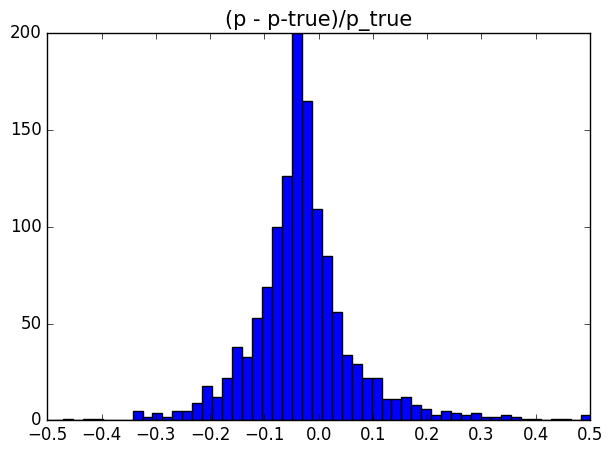

In [20]:
plt.figure(figsize=(7, 5))
plt.hist(p_err[~np.isnan(p_err)], bins=500)

plt.title('(p - p-true)/p_true', size=15)
p_err_min = np.min(p_err[~np.isnan(p_err)])
p_err_max = np.max(p_err[~np.isnan(p_err)])
plt.xticks(numpy.arange(-0.5, 0.51, 0.1), size=12)
plt.yticks(size=12)
plt.xlim([-0.5, 0.5])
plt.show()

In [16]:
p_err.argmax()

39

In [17]:
numpy.unique(data.EventID.values)[39]

475

# Event Efficiency (Treshold)

In [18]:
%%time

tresholds = np.linspace(0.2, 1, 15)
effs = []

for treshold in tresholds:
    
    ps = pandas.DataFrame(columns=['RecoEvents', 'Y12', 'Y34', 'Combination', 'Matching'])

    for event_id in event_ids:

        event = data[data.EventID == event_id]
        event12 = event[(event.StatNb == 1) + (event.StatNb == 2)]
        event34 = event[(event.StatNb == 3) + (event.StatNb == 4)]

        labels12 = tracks12[event_id]['labels']
        tracks_params12 = tracks12[event_id]['params']

        # Quality metrics of the reconstruction
        trm12 = TracksReconstractionMetrics(treshold)
        trm12.fit(labels12, event12)

        labels34 = tracks34[event_id]['labels']
        tracks_params34 = tracks34[event_id]['params']

        # Quality metrics of the reconstruction
        trm34 = TracksReconstractionMetrics(treshold)
        trm34.fit(labels34, event34)

        # Combination of the tracks before and after the magnet
        comb = Combinator()
        comb.combine(tracks_params12, tracks_params34)

        # Quality of the combination
        cq = CombinatorQuality()
        cq.fit(labels12, labels34, comb.tracks_combinations_, comb.charges_, comb.inv_momentums_, event12, event34)

        # Overall quality
        ps.loc[len(ps)] = numpy.array([1, 
                                       (trm12.recognition_efficiency_ == 1)*1,
                                       (trm34.recognition_efficiency_ == 1)*1, 
                                       (cq.n_combined_ >= 2)*1,
                                       (cq.reco_eff_ == 1)*1]).cumprod()

    bar_values = ps.sum(axis=0).values
    bar_values = bar_values / bar_values[0] * 100

    effs.append(bar_values[-1])
    
effs = np.array(effs)

CPU times: user 13.3 s, sys: 8 ms, total: 13.3 s
Wall time: 13.3 s


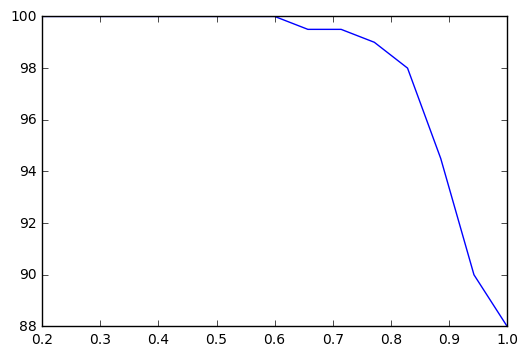

In [15]:
plt.plot(tresholds, effs)

# Analysis of big errors

In [38]:
for i in range(len(p_err)):
    if abs(p_err[i]) > 0.3:
        print event_ids[i]

126
824
1116
1251
1528
1722
1724
2040
2605
3386
3511
4281


In [31]:
def demonstration(data, event_id):
    
    event = data[data.EventID == event_id]
    
    track1, y1 = get_track_params(event, 3)
    track2, y2 = get_track_params(event, 4)
    
    retina = RetinaTrackReconstruction(z_scale=1500., pre_sigma=0.8, inlier_treshold=0.8, x_resolution=1, y_resolution=1,\
adjusting=True)
    
    dots, y0 = retina.fit(event)
    
    noise = event[((event.ViewNb==0)|(event.ViewNb==3))&(event.TrackID==-2)]

    y_track1b = event[((event.ViewNb==0)|(event.ViewNb==3))&(event.TrackID==3)&(event.StatNb<3)]
    y_track1a = event[((event.ViewNb==0)|(event.ViewNb==3))&(event.TrackID==3)&(event.StatNb>2)]
    y_track_params1b = np.polyfit(y_track1b.Z.values, y_track1b.Y.values, 1)
    y_track_params1a = np.polyfit(y_track1a.Z.values, y_track1a.Y.values, 1)

    y_track2b = event[(event.TrackID==4)&(event.StatNb<3)]
    y_track2a = event[(event.TrackID==4)&(event.StatNb>2)]
    y_track_params2b = np.polyfit(y_track2b.Z.values, y_track2b.Y.values, 1)
    y_track_params2a = np.polyfit(y_track2a.Z.values, y_track2a.Y.values, 1)

    y_track1b = y_track1b[(event.ViewNb==0)|(event.ViewNb==3)]
    y_track1a = y_track1a[(event.ViewNb==0)|(event.ViewNb==3)]
    y_track2b = y_track2b[(event.ViewNb==0)|(event.ViewNb==3)]
    y_track2a = y_track2a[(event.ViewNb==0)|(event.ViewNb==3)]

    min_z = 2500
    max_z = 3600
    mid_z = 3070

    plt.figure(figsize=(16, 5))
    #plt.subplot(1,2,1)
    plt.scatter(noise.Wz.values, noise.Wy1.values, c='yellow')
    plt.scatter(y_track1a.Wz.values, y_track1a.Wy1.values, c='red')
    plt.scatter(y_track1b.Wz.values, y_track1b.Wy1.values, c='red')
    #plt.scatter(y_track2a.Wz.values, y_track2a.Wy1.values, c='black')
    #plt.scatter(y_track2b.Wz.values, y_track2b.Wy1.values, c='black')
    plt.plot([min_z, mid_z], [y0[0] + dots[0][-1][2]*(min_z-mid_z), y0[0]], c='green')
    plt.plot([mid_z, max_z], [y0[0], y0[0] + dots[0][-1][3]*(max_z-mid_z)], c='green')
    #plt.plot([min_z, mid_z], [y0[1] + dots[1][-1][2]*(min_z-mid_z), y0[1]], c='blue')
    #plt.plot([mid_z, max_z], [y0[1], y0[1] + dots[1][-1][3]*(max_z-mid_z)], c='blue')
    plt.plot([min_z, mid_z], [y_track_params1b[1] + min_z*y_track_params1b[0], y_track_params1b[1] + mid_z*y_track_params1b[0]], c='red')
    #plt.plot([min_z, mid_z], [y_track_params2b[1] + min_z*y_track_params2b[0], y_track_params2b[1] + mid_z*y_track_params2b[0]], c='black')
    plt.plot([mid_z, max_z], [y_track_params1a[1] + mid_z*y_track_params1a[0], y_track_params1a[1] + max_z*y_track_params1a[0]], c='red')
    #plt.plot([mid_z, max_z], [y_track_params2a[1] + mid_z*y_track_params2a[0], y_track_params2a[1] + max_z*y_track_params2a[0]], c='black')
    
    #plt.subplot(1,2,2)
    #plt.plot([min_z, max_z], [track1[0] + (min_z-mid_z)*track1[1], track1[0] + (max_z-mid_z)*track1[1]], c='red')
    #plt.plot([min_z, max_z], [track2[0] + (min_z-mid_z)*track2[1], track2[0] + (max_z-mid_z)*track2[1]], c='black')
    #plt.plot([min_z, max_z], [dots[0][-1][0] + (min_z-mid_z)*dots[0][-1][1], dots[0][-1][0] + (max_z-mid_z)*dots[0][-1][1]], c='green')
    #plt.plot([min_z, max_z], [dots[1][-1][0] + (min_z-mid_z)*dots[1][-1][1], dots[1][-1][0] + (max_z-mid_z)*dots[1][-1][1]], c='blue')

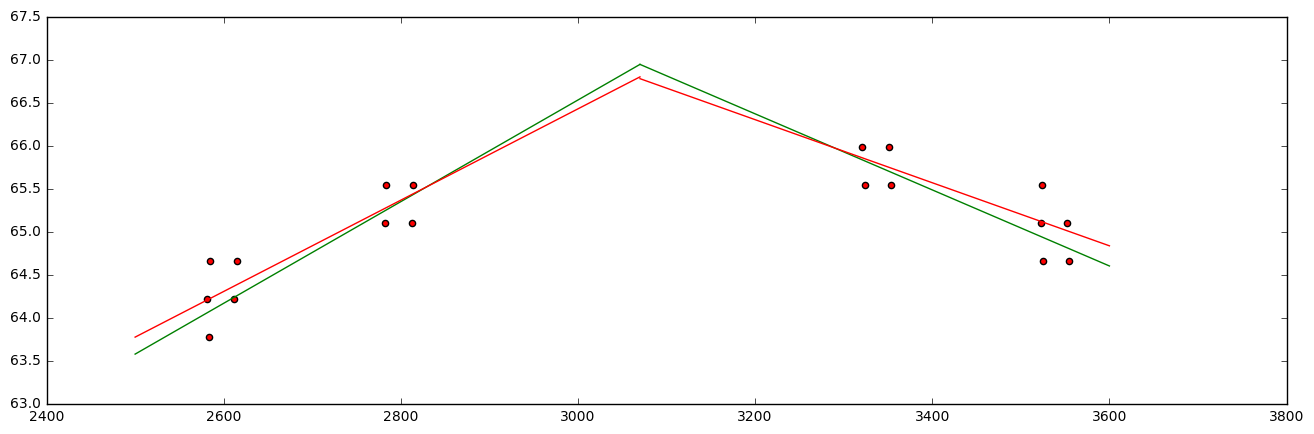

In [32]:
demonstration(data, 475)

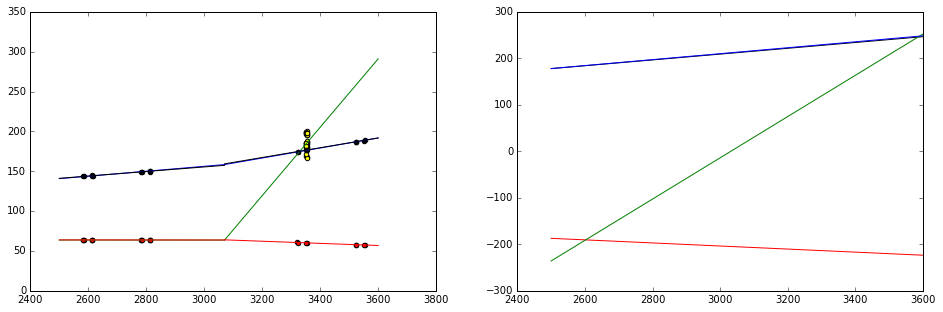

In [18]:
demonstration(data, 916)

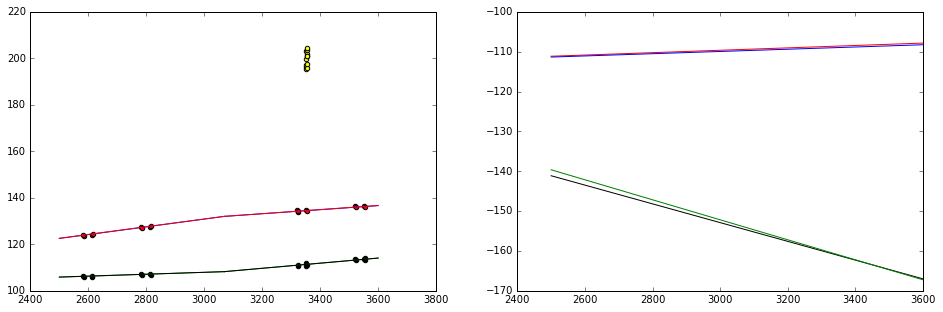

In [19]:
demonstration(data, 1284)

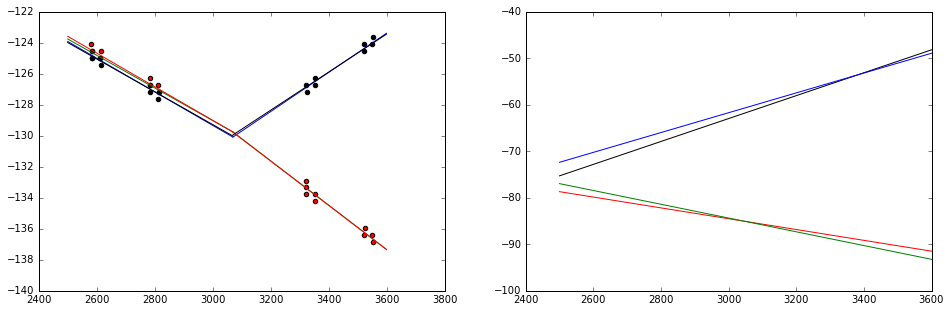

In [20]:
demonstration(data, 3085)

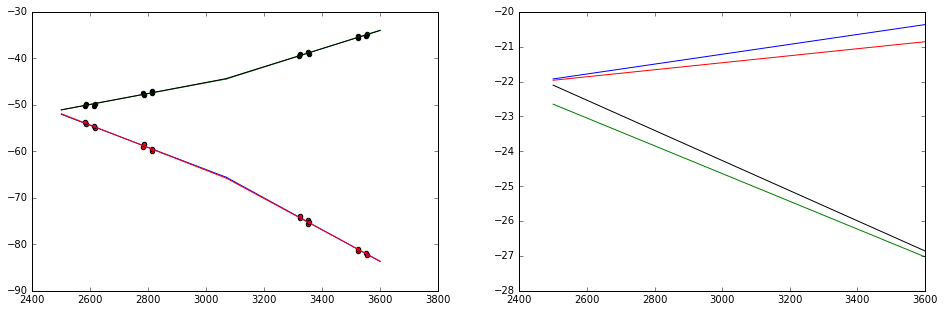

In [21]:
demonstration(data, 3439)

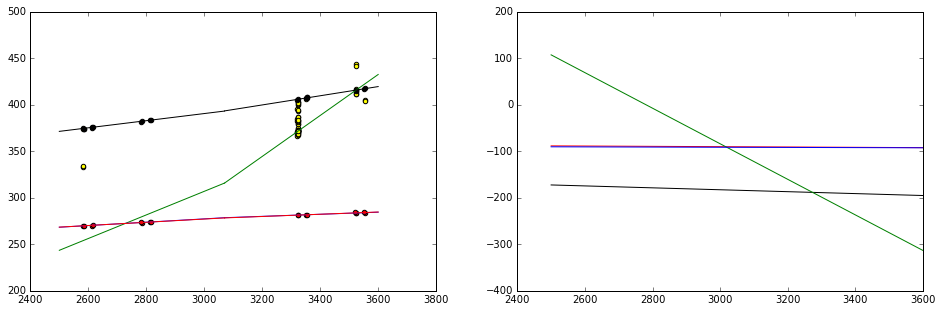

In [22]:
demonstration(data, 3497)

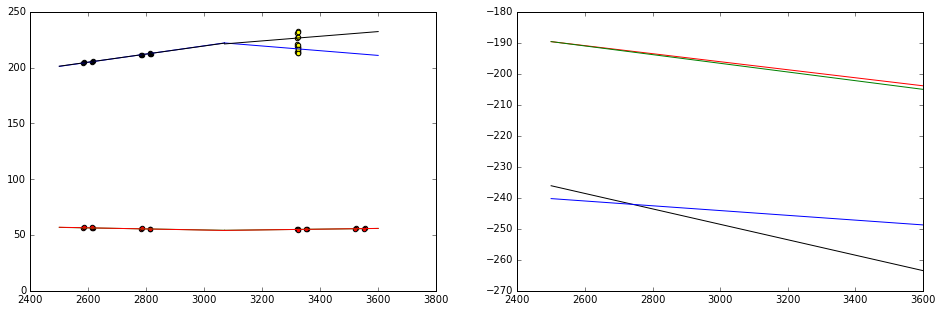

In [23]:
demonstration(data, 3670)

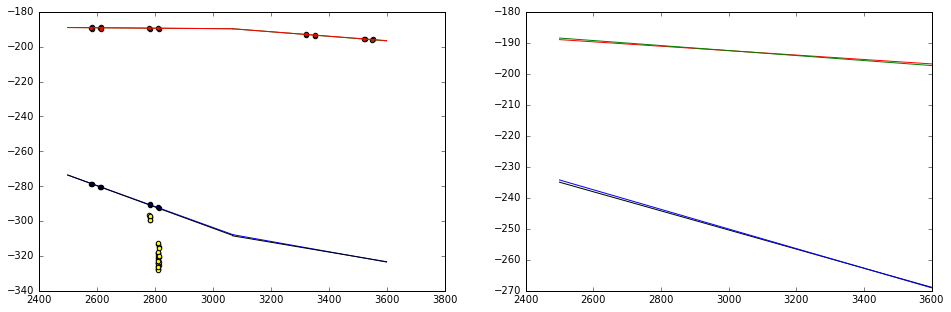

In [24]:
demonstration(data, 3781)

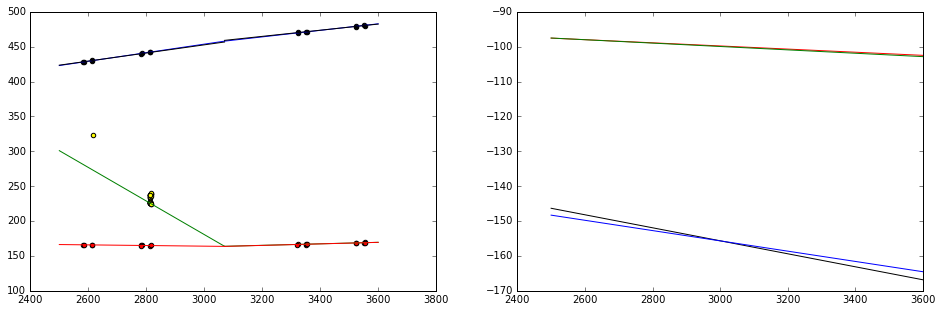

In [25]:
demonstration(data, 3942)

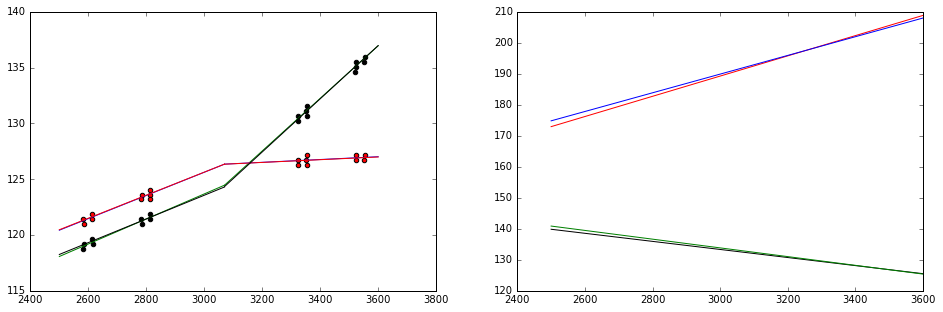

In [26]:
demonstration(data, 4108)

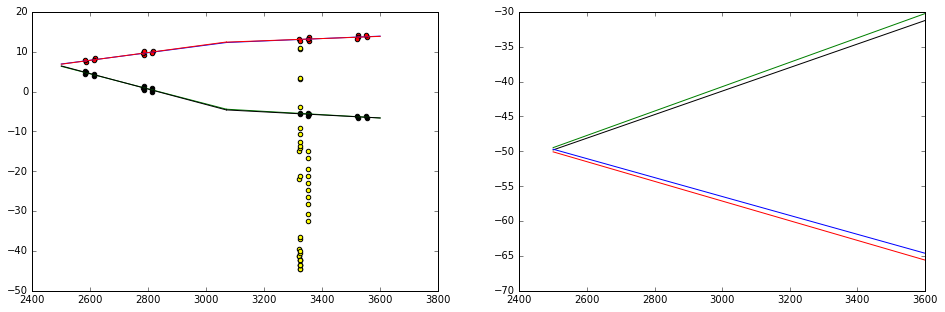

In [27]:
demonstration(data, 4175)

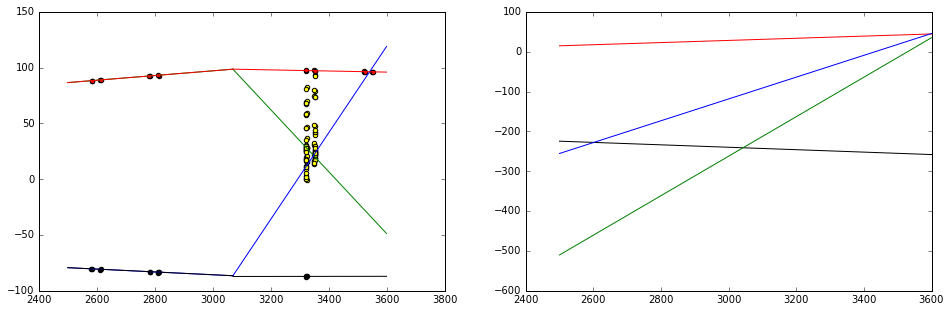

In [28]:
demonstration(data, 4490)

In [29]:
passed_events[39]

475

In [30]:
p_err.max()

0.47167091927004545